In [1]:
import pandas as pd
import requests
from sklearn.metrics import roc_auc_score
from src.metrics import business_cost
import matplotlib.pyplot as plt

API_URL = "http://127.0.0.1:8000/predict"

/Users/lukaslaudrain/Library/Mobile Documents/com~apple~CloudDocs/Documents/Cours/2025-2026/majeur-ia/credit-scoring/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('../data/processed/train_final.csv')

import re
df = df.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

SAMPLE_SIZE = 200
df_sample = df.sample(SAMPLE_SIZE, random_state=42)

In [4]:
# On prend le premier client de l'échantillon
client_0 = df_sample.iloc[0]

# On sépare les features de la cible
features_0 = client_0.drop(['SK_ID_CURR', 'TARGET']).to_dict()
true_label = client_0['TARGET']

# APPEL API
try:
    response = requests.post(API_URL, json={'features': features_0})

    if response.status_code == 200:
        result = response.json()
        print("✅ Réponse API reçue !")
        print(f"   - Probabilité : {result['probability']:.4f}")
        print(f"   - Seuil utilisé : {result['threshold']}")
        print(f"   - Décision : {result['decision']}")
        print(f"   - Vraie Classe : {true_label}")
    else:
        print(f"Erreur API : {response.status_code}")
        print(response.text)
except Exception as e:
    print(f"Exception lors de l'appel API : {e}")

✅ Réponse API reçue !
   - Probabilité : 0.1745
   - Seuil utilisé : 0.53
   - Décision : ACCORDÉ
   - Vraie Classe : 0


In [15]:
import numpy as np

y_true = []
y_pred_proba = []
y_pred_decision = []

print(f"⏳ Lancement du test sur {SAMPLE_SIZE} clients...")

for index, row in df_sample.iterrows():
    # Préparation
    true_val = row['TARGET']
    features = row.drop(['SK_ID_CURR', 'TARGET']).replace([np.inf, -np.inf, np.nan], None).to_dict()

    # Appel API
    try:
        resp = requests.post(API_URL, json={'features': features})
        if resp.status_code == 200:
            res_json = resp.json()

            # Stockage
            y_true.append(true_val)
            y_pred_proba.append(res_json['probability'])
            # On convertit "REFUSÉ" en 1 et "ACCORDÉ" en 0 pour les métriques
            decision_bin = 1 if res_json['decision'] == "REFUSÉ" else 0
            y_pred_decision.append(decision_bin)
    except Exception as e:
        print(f"Exception lors de l'appel API pour l'index {index} : {e}")

⏳ Lancement du test sur 200 clients...


RÉSULTATS DU TEST DE SERVING :
   -> AUC calculé via API : 0.5011
   -> Coût Métier via API : 1.3376


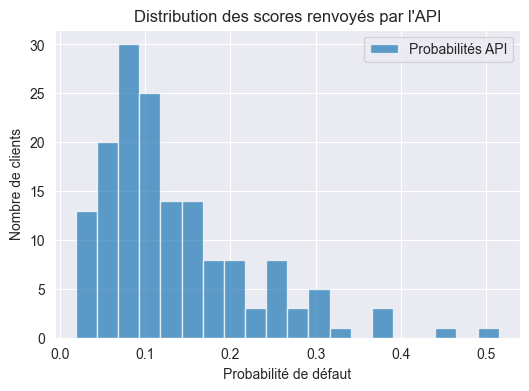

In [16]:
# 1. Calcul de l'AUC sur les réponses de l'API
auc_api = roc_auc_score(y_true, y_pred_proba)

# 2. Calcul du Coût Métier
cost_api = business_cost(y_true, y_pred_decision, fn_cost=10, fp_cost=1)

print("RÉSULTATS DU TEST DE SERVING :")
print(f"   -> AUC calculé via API : {auc_api:.4f}")
print(f"   -> Coût Métier via API : {cost_api:.4f}")

# Petit graphique de contrôle
plt.figure(figsize=(6,4))
plt.hist(y_pred_proba, bins=20, alpha=0.7, label='Probabilités API')
plt.title("Distribution des scores renvoyés par l'API")
plt.xlabel("Probabilité de défaut")
plt.ylabel("Nombre de clients")
plt.legend()
plt.show()